# Predicting Telco Customer Churn using SparkML on IBM Cloud Pak for Data (ICP4D)

We'll use this notebook to create a machine learning model to predict customer churn. In this notebook we will build the prediction model using the SparkML library.

This notebook walks you through these steps:

- Load and Visualize data set.
- Build a predictive model with SparkML API
- Save the model in the ML repository

## 1.0 Install required packages

There are a couple of Python packages we will use in this notebook. First we make sure the Watson Machine Learning client v3 is removed (its not installed by default) and then install/upgrade the v4 version of the client (this package is installed by default on CP4D).

WML Client: https://wml-api-pyclient-dev-v4.mybluemix.net/#repository

In [1]:
%pip uninstall watson-machine-learning-client -y
%pip install --user watson-machine-learning-client-v4==1.0.103 --upgrade | tail -n 1
%pip install --user pyspark==2.3.3 --upgrade|tail -n 1
%pip install --user scikit-learn==0.20.3 --upgrade|tail -n 1

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


'tail' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


'tail' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


'tail' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

'''# Import the Project Library to read/write project assets
from project_lib import Project
project = Project.access()

import warnings
warnings.filterwarnings("ignore")'''

'# Import the Project Library to read/write project assets\nfrom project_lib import Project\nproject = Project.access()\n\nimport warnings\nwarnings.filterwarnings("ignore")'

## 2.0 Load and Clean data

We'll load our data as a pandas data frame.

In [42]:
df_data_1 = pd.read_csv(r'data\Telco-Customer-Churn.csv')

In [43]:
# for virtualized data
# df = data_df_1

# for local upload
df = df_data_1

### 2.1 Drop CustomerID feature (column)

In [44]:
df = df.drop('customerID', axis=1)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2.2 Examine the data types of the features

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [46]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


We see that Tenure ranges from 0 (new customer) to 6 years, Monthly charges range from $18 to $118, etc

### 2.3 Check for need to Convert TotalCharges column to numeric if it is detected as object

If the above `df.info` shows the "TotalCharges" columnn as an object, we'll need to convert it to numeric. If you have already done this during a previous exercise for "Data Visualization with Data Refinery", you can skip to step `2.4`.

In [47]:
totalCharges = df.columns.get_loc("TotalCharges")
new_col = pd.to_numeric(df.iloc[:, totalCharges], errors='coerce')
df.iloc[:, totalCharges] = pd.Series(new_col)

In [48]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032.0,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6530.0,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11.0,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


We now see statistics for the `TotalCharges` feature.



### 2.4 Any NaN values should be removed to create a more accurate model.

In [49]:
# Check if we have any NaN values and see which features have missing values that should be addressed
print(df.isnull().values.any())
df.isnull().sum()

True


gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We should see that the `TotalCharges` column has missing values. There are various ways we can address this issue:

- Drop records with missing values 
- Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [50]:
# Handle missing values for nan_column (TotalCharges)
from sklearn.impute import SimpleImputer

# Find the column number for TotalCharges (starting at 0).
total_charges_idx = df.columns.get_loc("TotalCharges")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df.iloc[:, total_charges_idx] = imputer.fit_transform(df.iloc[:, total_charges_idx].values.reshape(-1, 1))
df.iloc[:, total_charges_idx] = pd.Series(df.iloc[:, total_charges_idx])

In [51]:
# Validate that we have addressed any NaN values
print(df.isnull().values.any())
df.isnull().sum()

False


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### 2.5 Categorize Features

We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [52]:
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != 'Churn']
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != 'Churn']
continuous_features = [x for x in all_features if x not in categorical_features]

#print('All Features: ', all_features)
#print('\nCategorical Features: ', categorical_features)
#print('\nContinuous Features: ', continuous_features)
#print('\nAll Categorical Columns: ', categorical_columns)

### 2.6 Visualize data

Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:

- Histograms, boxplots, etc: To find distribution / spread of our continuous variables.
- Bar charts: To show frequency in categorical values.


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

First, we get a high level view of the distribution of `Churn`. What percentage of customer in our dataset are churning vs not churning. 

Churn
No     5174
Yes    1869
dtype: int64


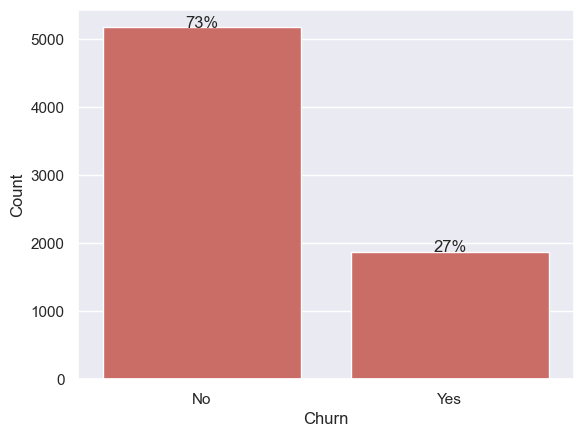

In [54]:
print(df.groupby(['Churn']).size())
churn_plot = sns.countplot(data=df, x='Churn', order=df.Churn.value_counts().index)
plt.ylabel('Count')
for p in churn_plot.patches:
    height = p.get_height()
    churn_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

We can get use frequency counts charts to get an understanding of the categorical features relative to `Churn`  

- We can see that for the `gender` feature. We have relatively equal rates of churn by `gender`
- We can see that for the `InternetService` feature. We have higher churn for those that have "Fiber optic" service versus those with "DSL"


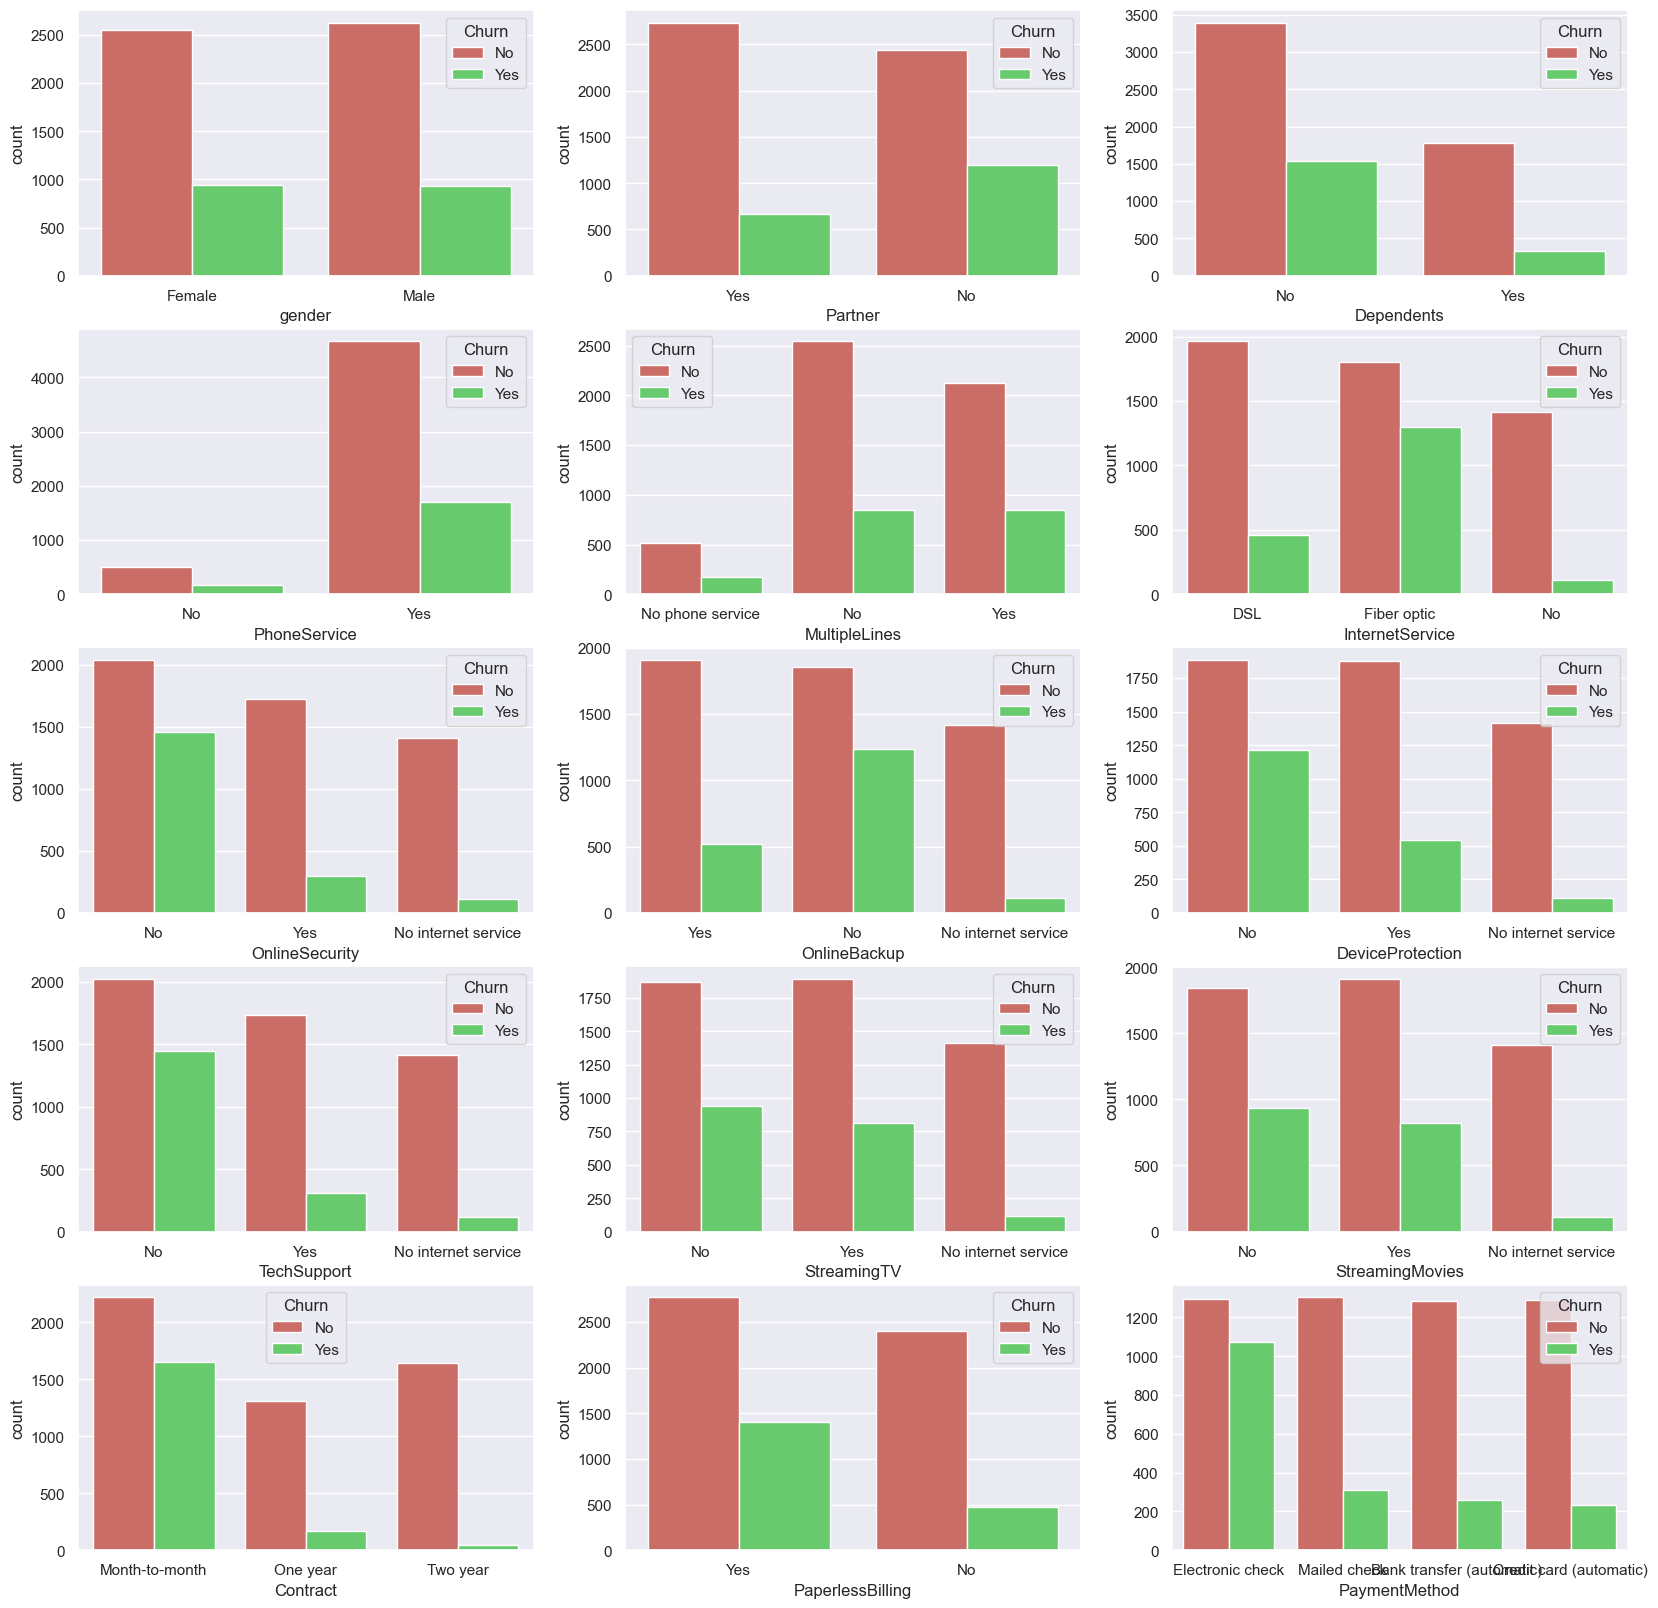

In [55]:
# Categorical feature count plots
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(20, 20))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15 ]

for i in range(len(categorical_features)):
    sns.countplot(x = categorical_features[i], hue="Churn", data=df, ax=ax[i])

We can get use histrogram charts to get an understanding of the distribution of our continuous / numerical features relative to Churn.

- We can see that for the `MonthlyCharges` feature, customers that churn tend to pay higher monthly fees than those that stay.
- We can see that for the `tenure` feature, customers that churn tend to be relatively new customers.

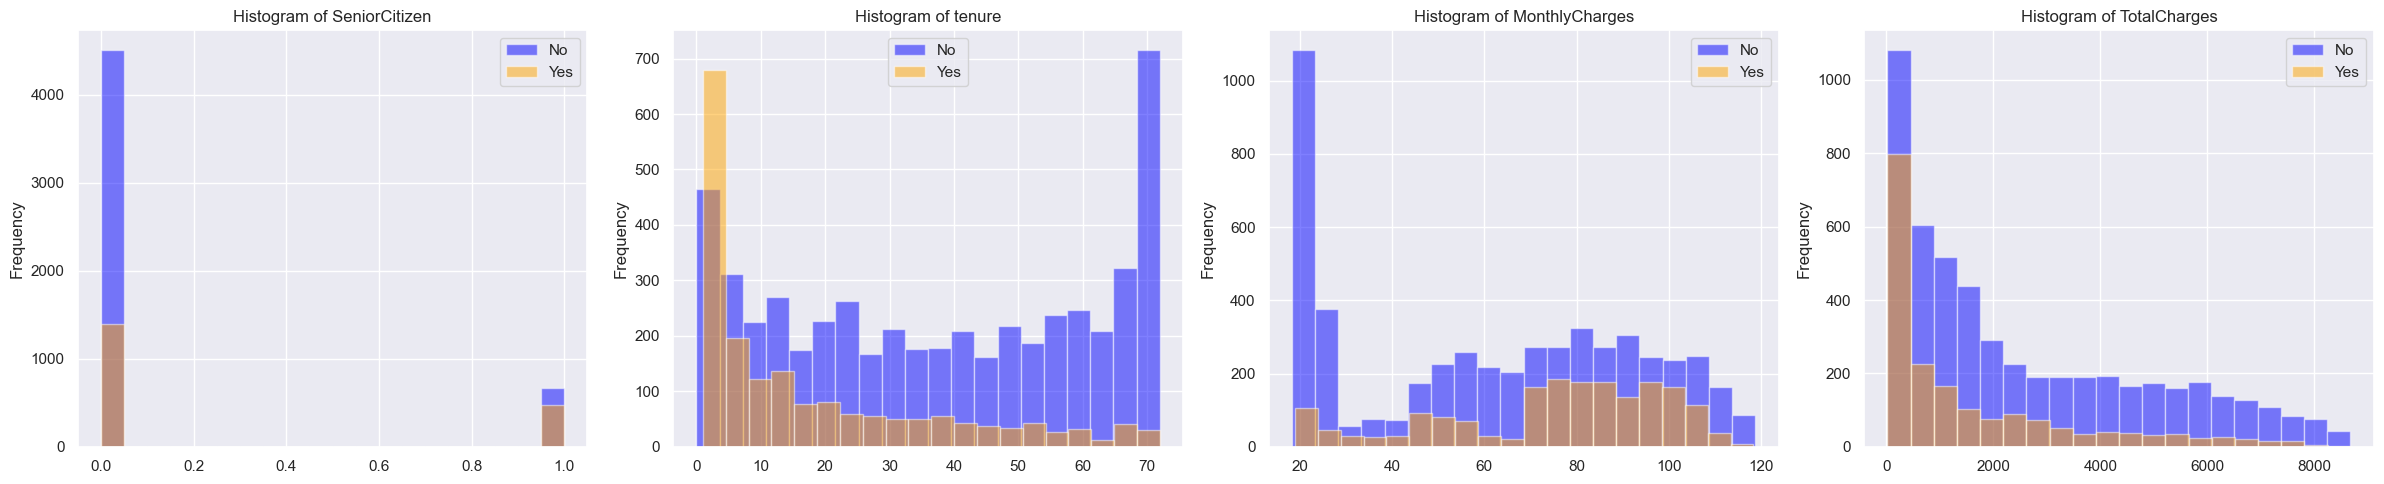

In [56]:
# Create the appropriate number of subplots in a row
# Continuous feature histograms.
fig, ax = plt.subplots(1, len(continuous_features), figsize=(6 * len(continuous_features), 5))

for i, col in enumerate(continuous_features):
    df[df.Churn == 'No'][col].plot(kind='hist', bins=20, color="blue", alpha=0.5, ax=ax[i], label='No')
    df[df.Churn == 'Yes'][col].plot(kind='hist', bins=20, color="orange", alpha=0.5, ax=ax[i], label='Yes')
    ax[i].set_title(f"Histogram of {col}")
    ax[i].legend()

plt.tight_layout()
plt.show()


# Or use displots
#sns.set_palette("hls", 3)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
#ax = [ax1, ax2, ax3, ax4]
#for i in range(len(continuous_features)):
#    sns.distplot(df[continuous_features[i]], bins=20, hist=True, ax=ax[i])

C:\Users\LEGION\AppData\Local\Temp\ipykernel_30892\2941118145.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[continuous_features[i]], bins=20, hist=True, ax=ax[i])
C:\Users\LEGION\AppData\Local\Temp\ipykernel_30892\2941118145.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[continu

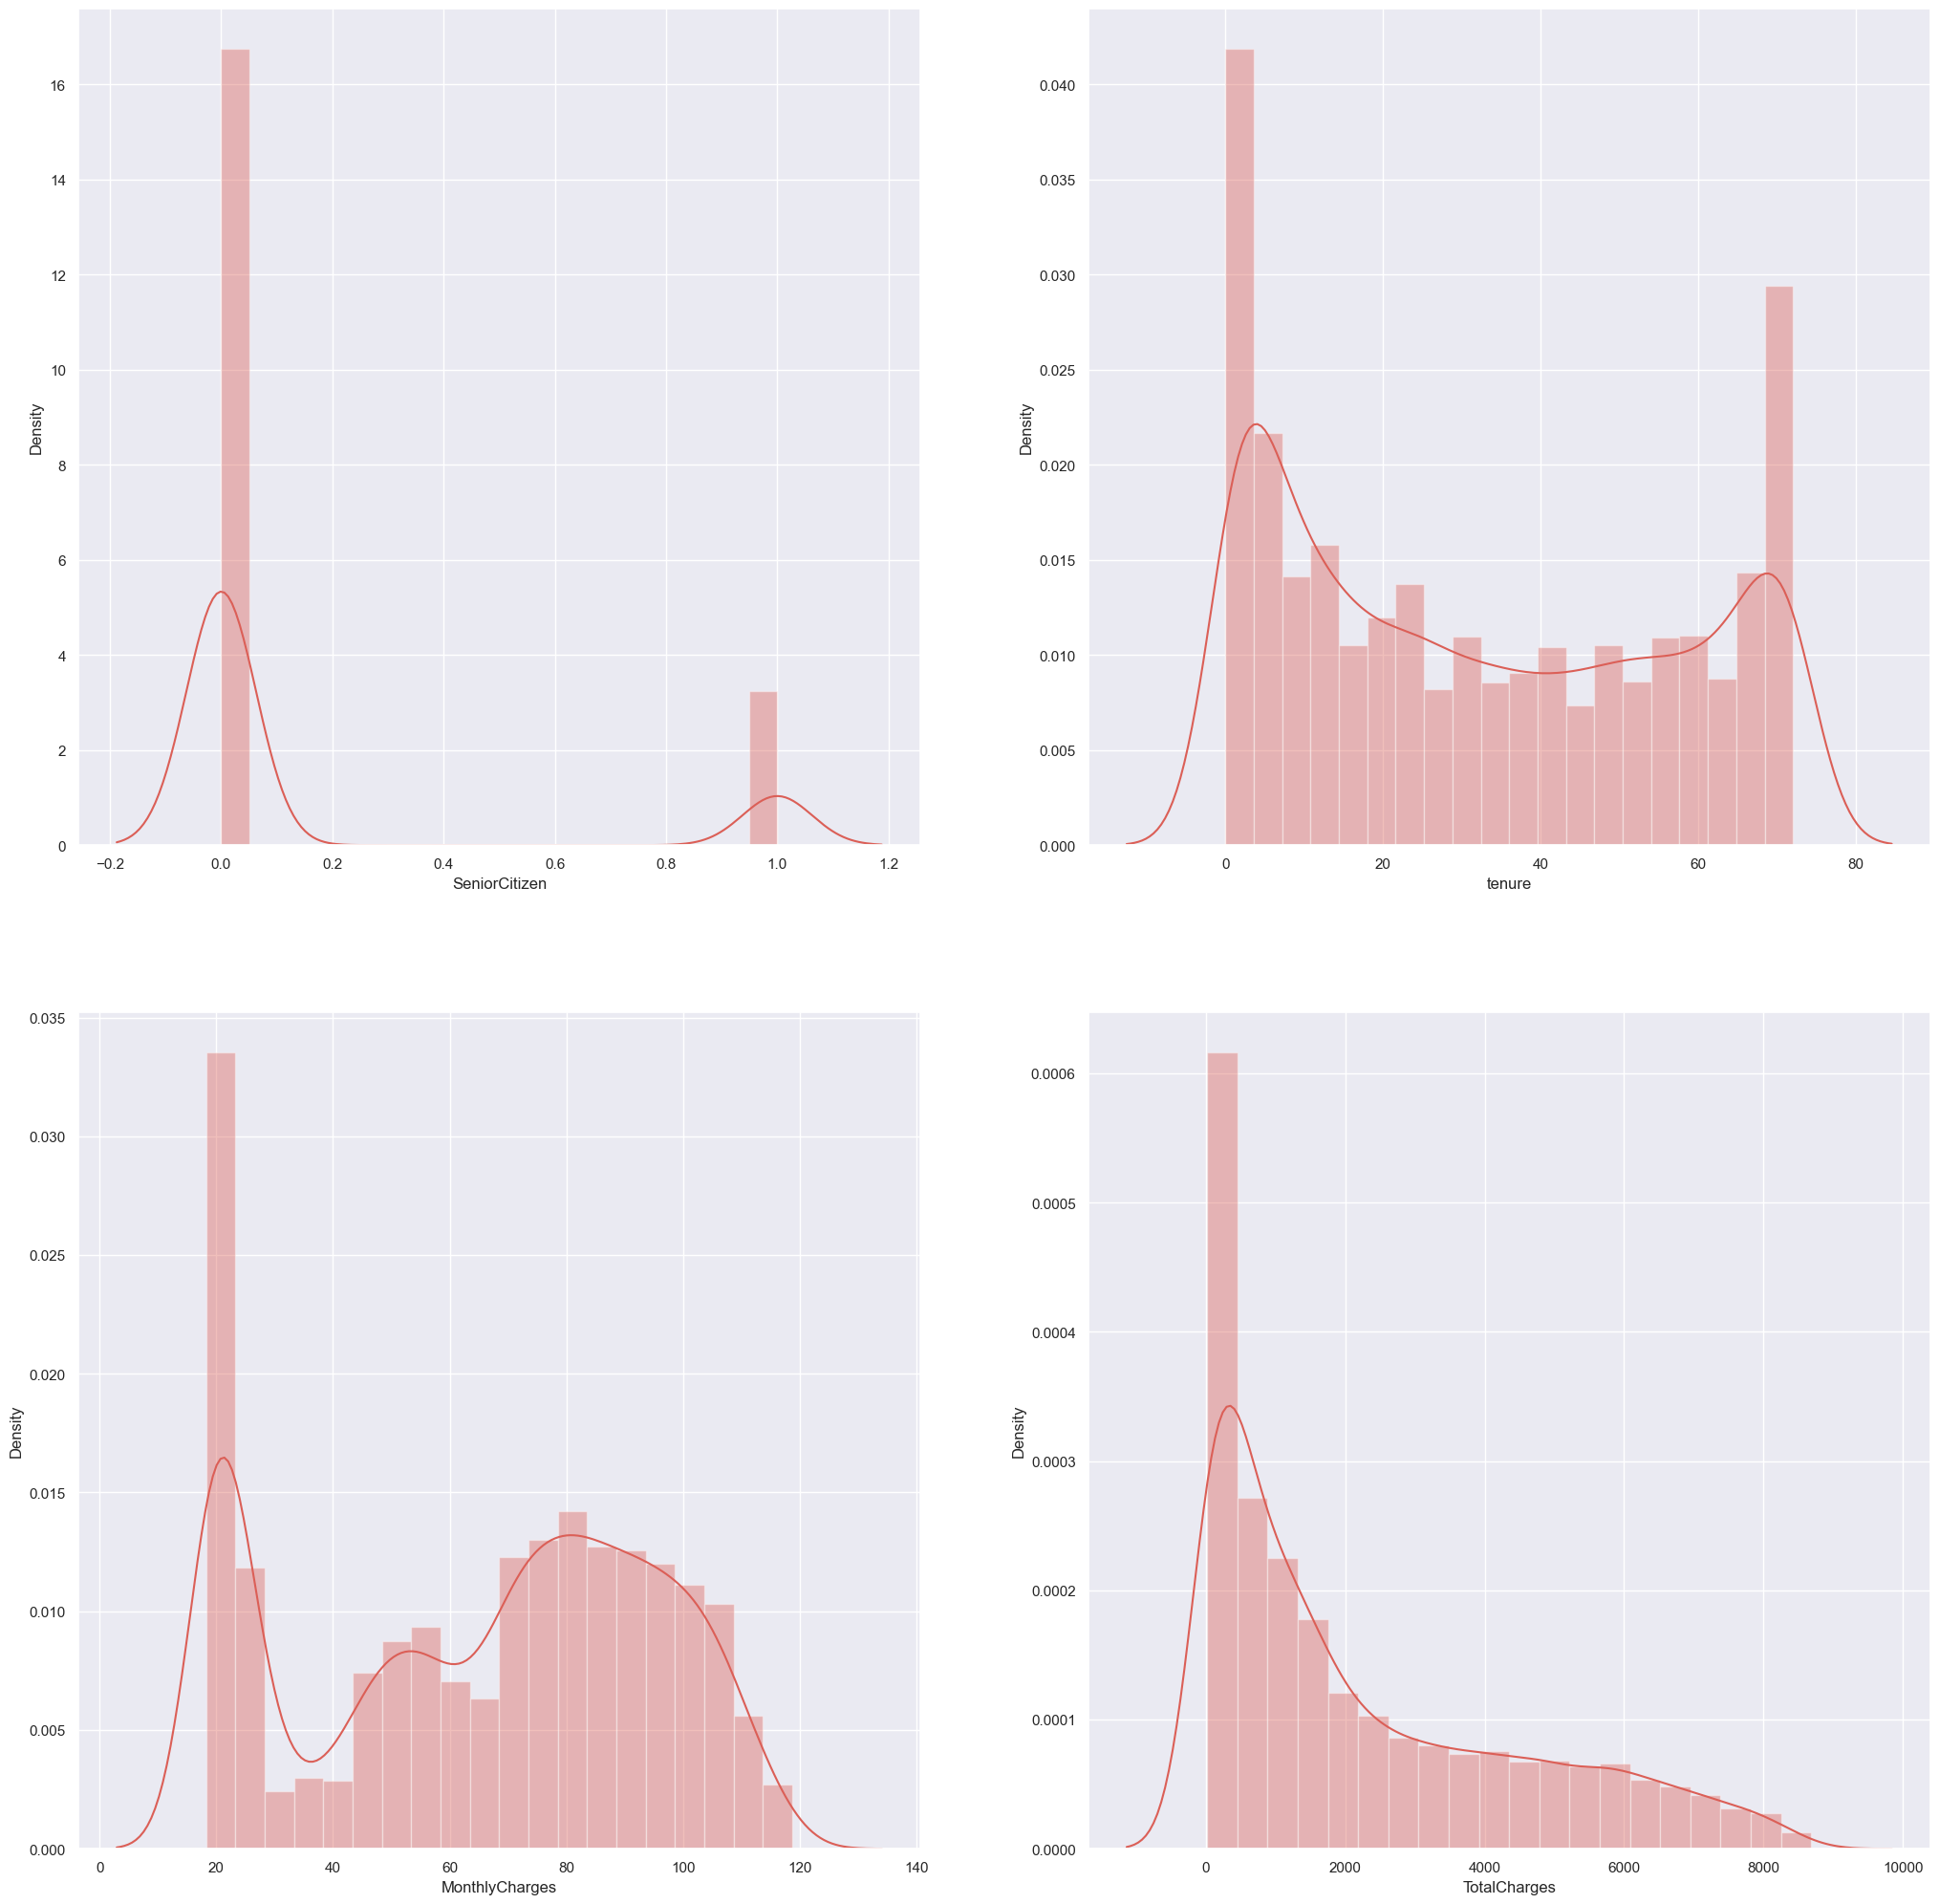

In [57]:
# Displots
sns.set_palette("hls", 3)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4]
for i in range(len(continuous_features)):
    sns.distplot(df[continuous_features[i]], bins=20, hist=True, ax=ax[i])

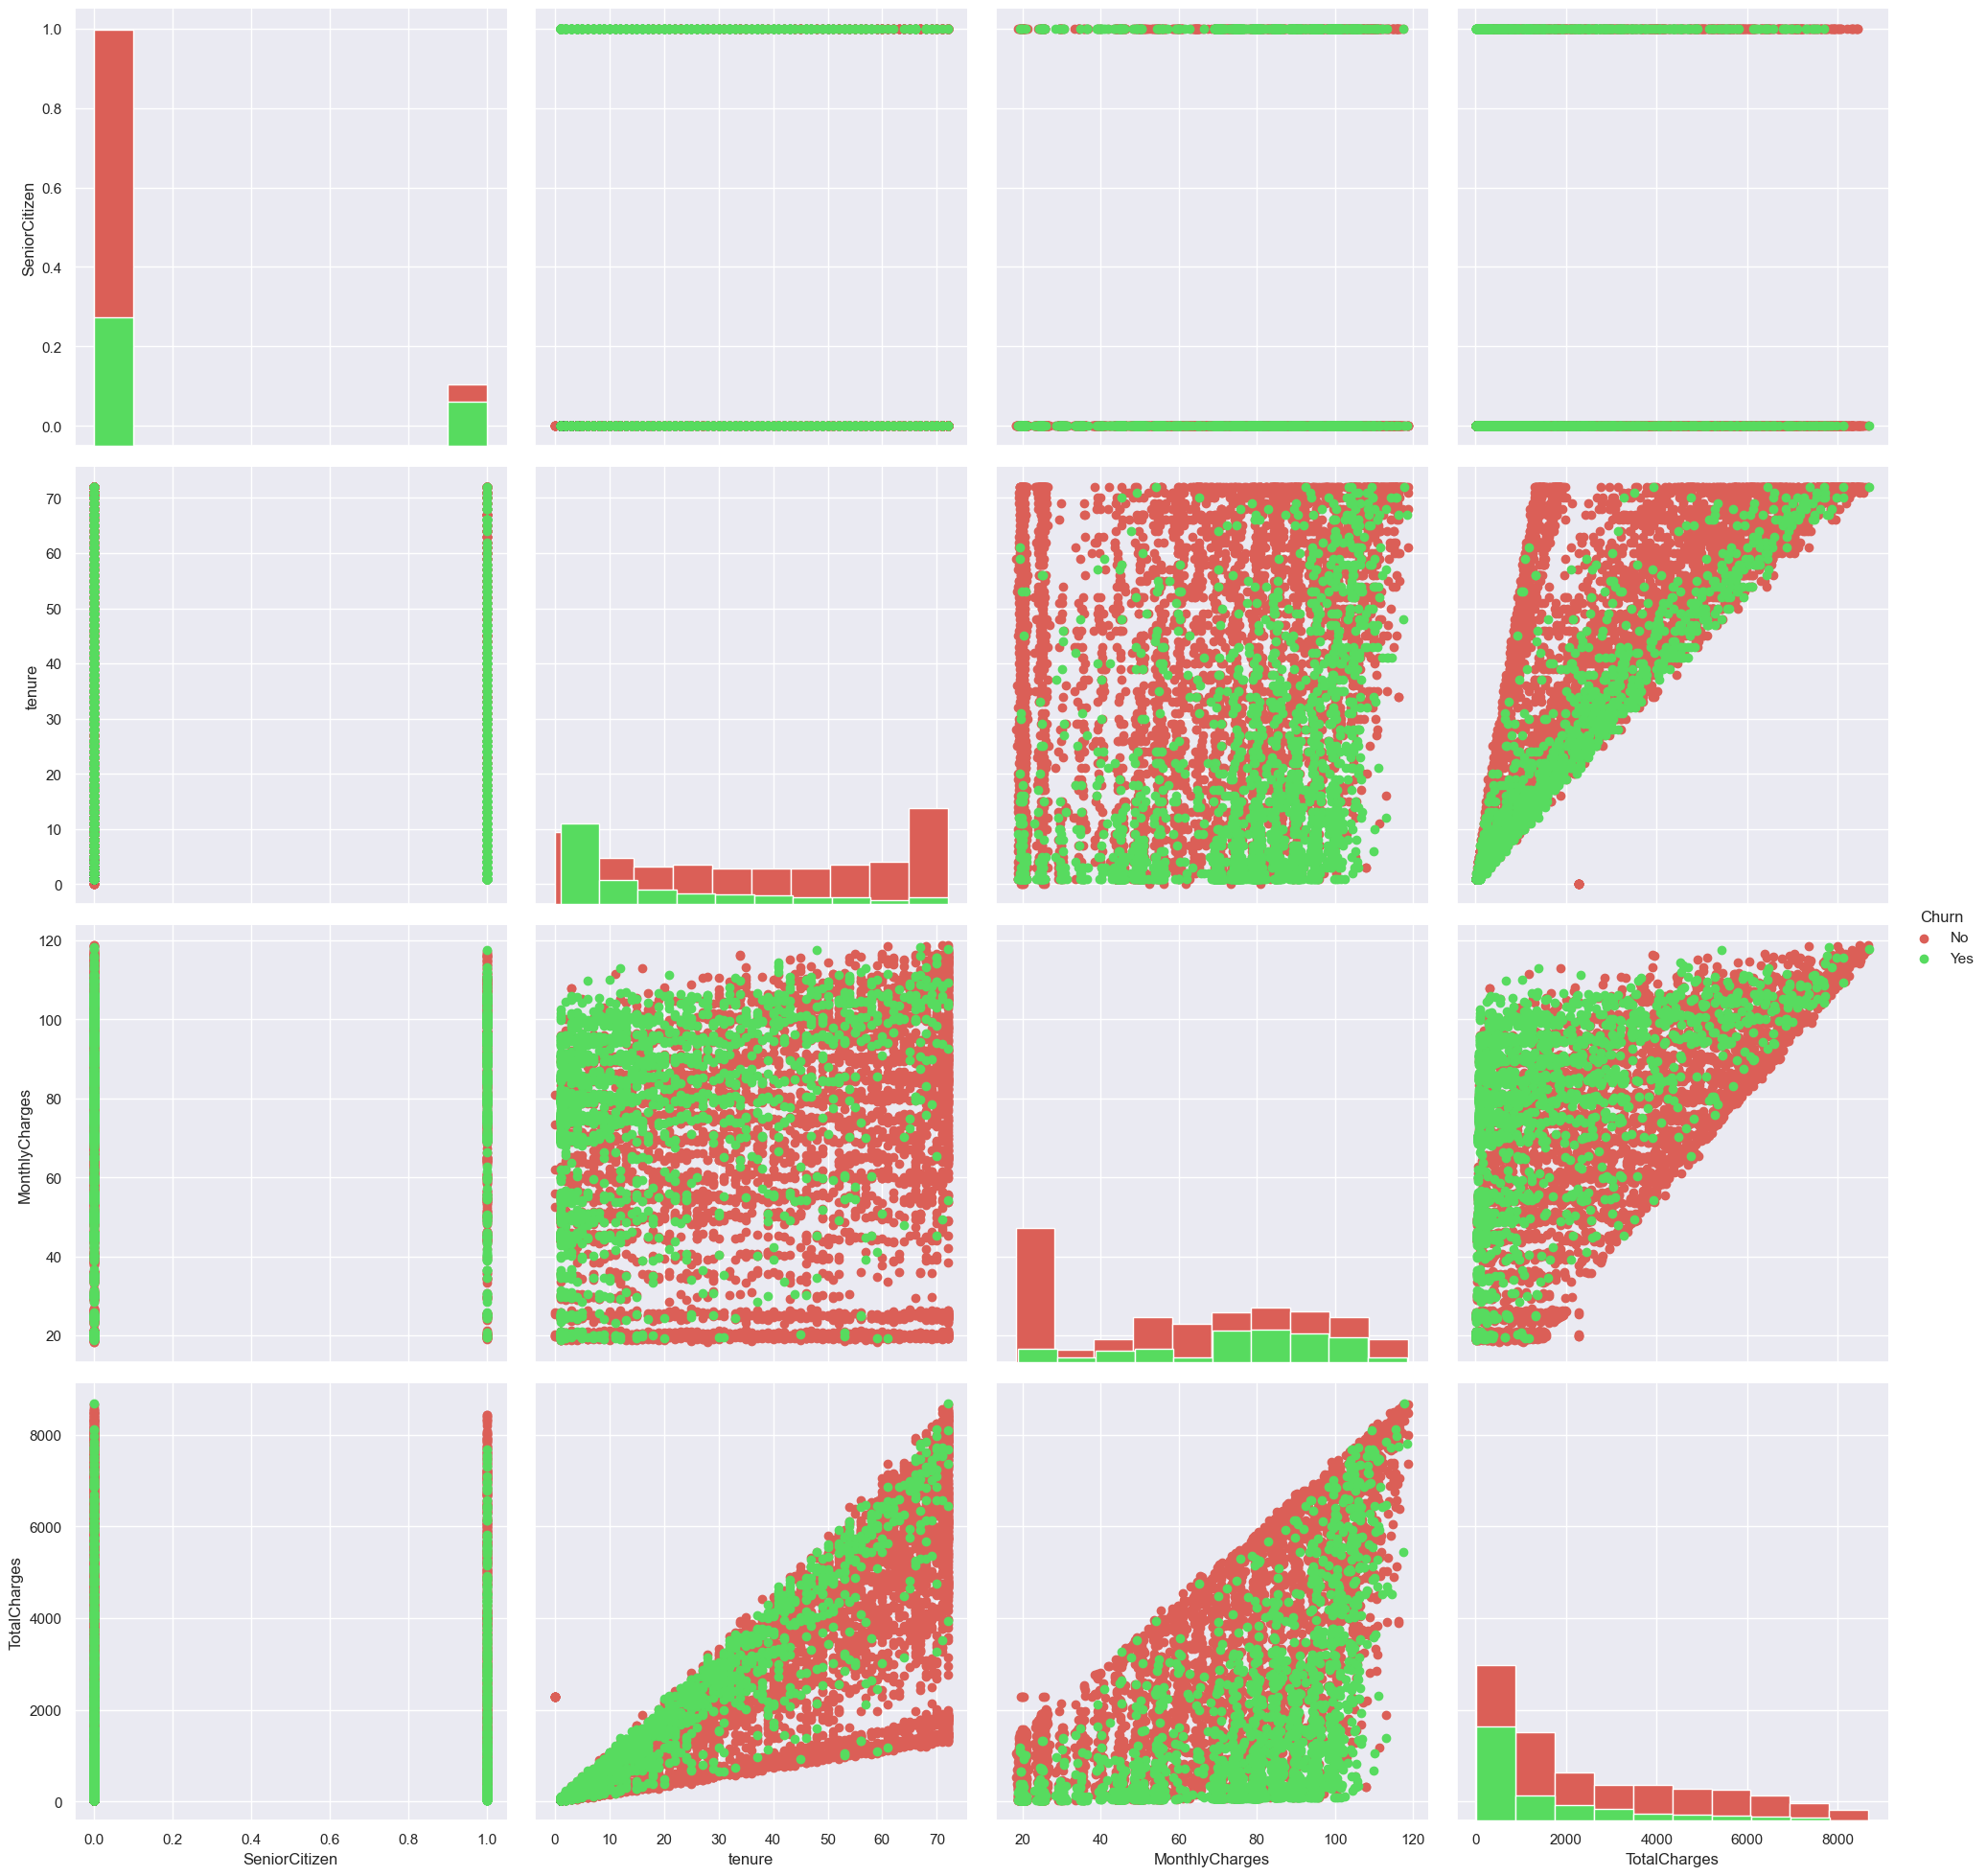

In [58]:
# Create Grid for pairwise relationships
gr = sns.PairGrid(df, height=5, hue="Churn")
gr = gr.map_diag(plt.hist)
gr = gr.map_offdiag(plt.scatter)
gr = gr.add_legend()

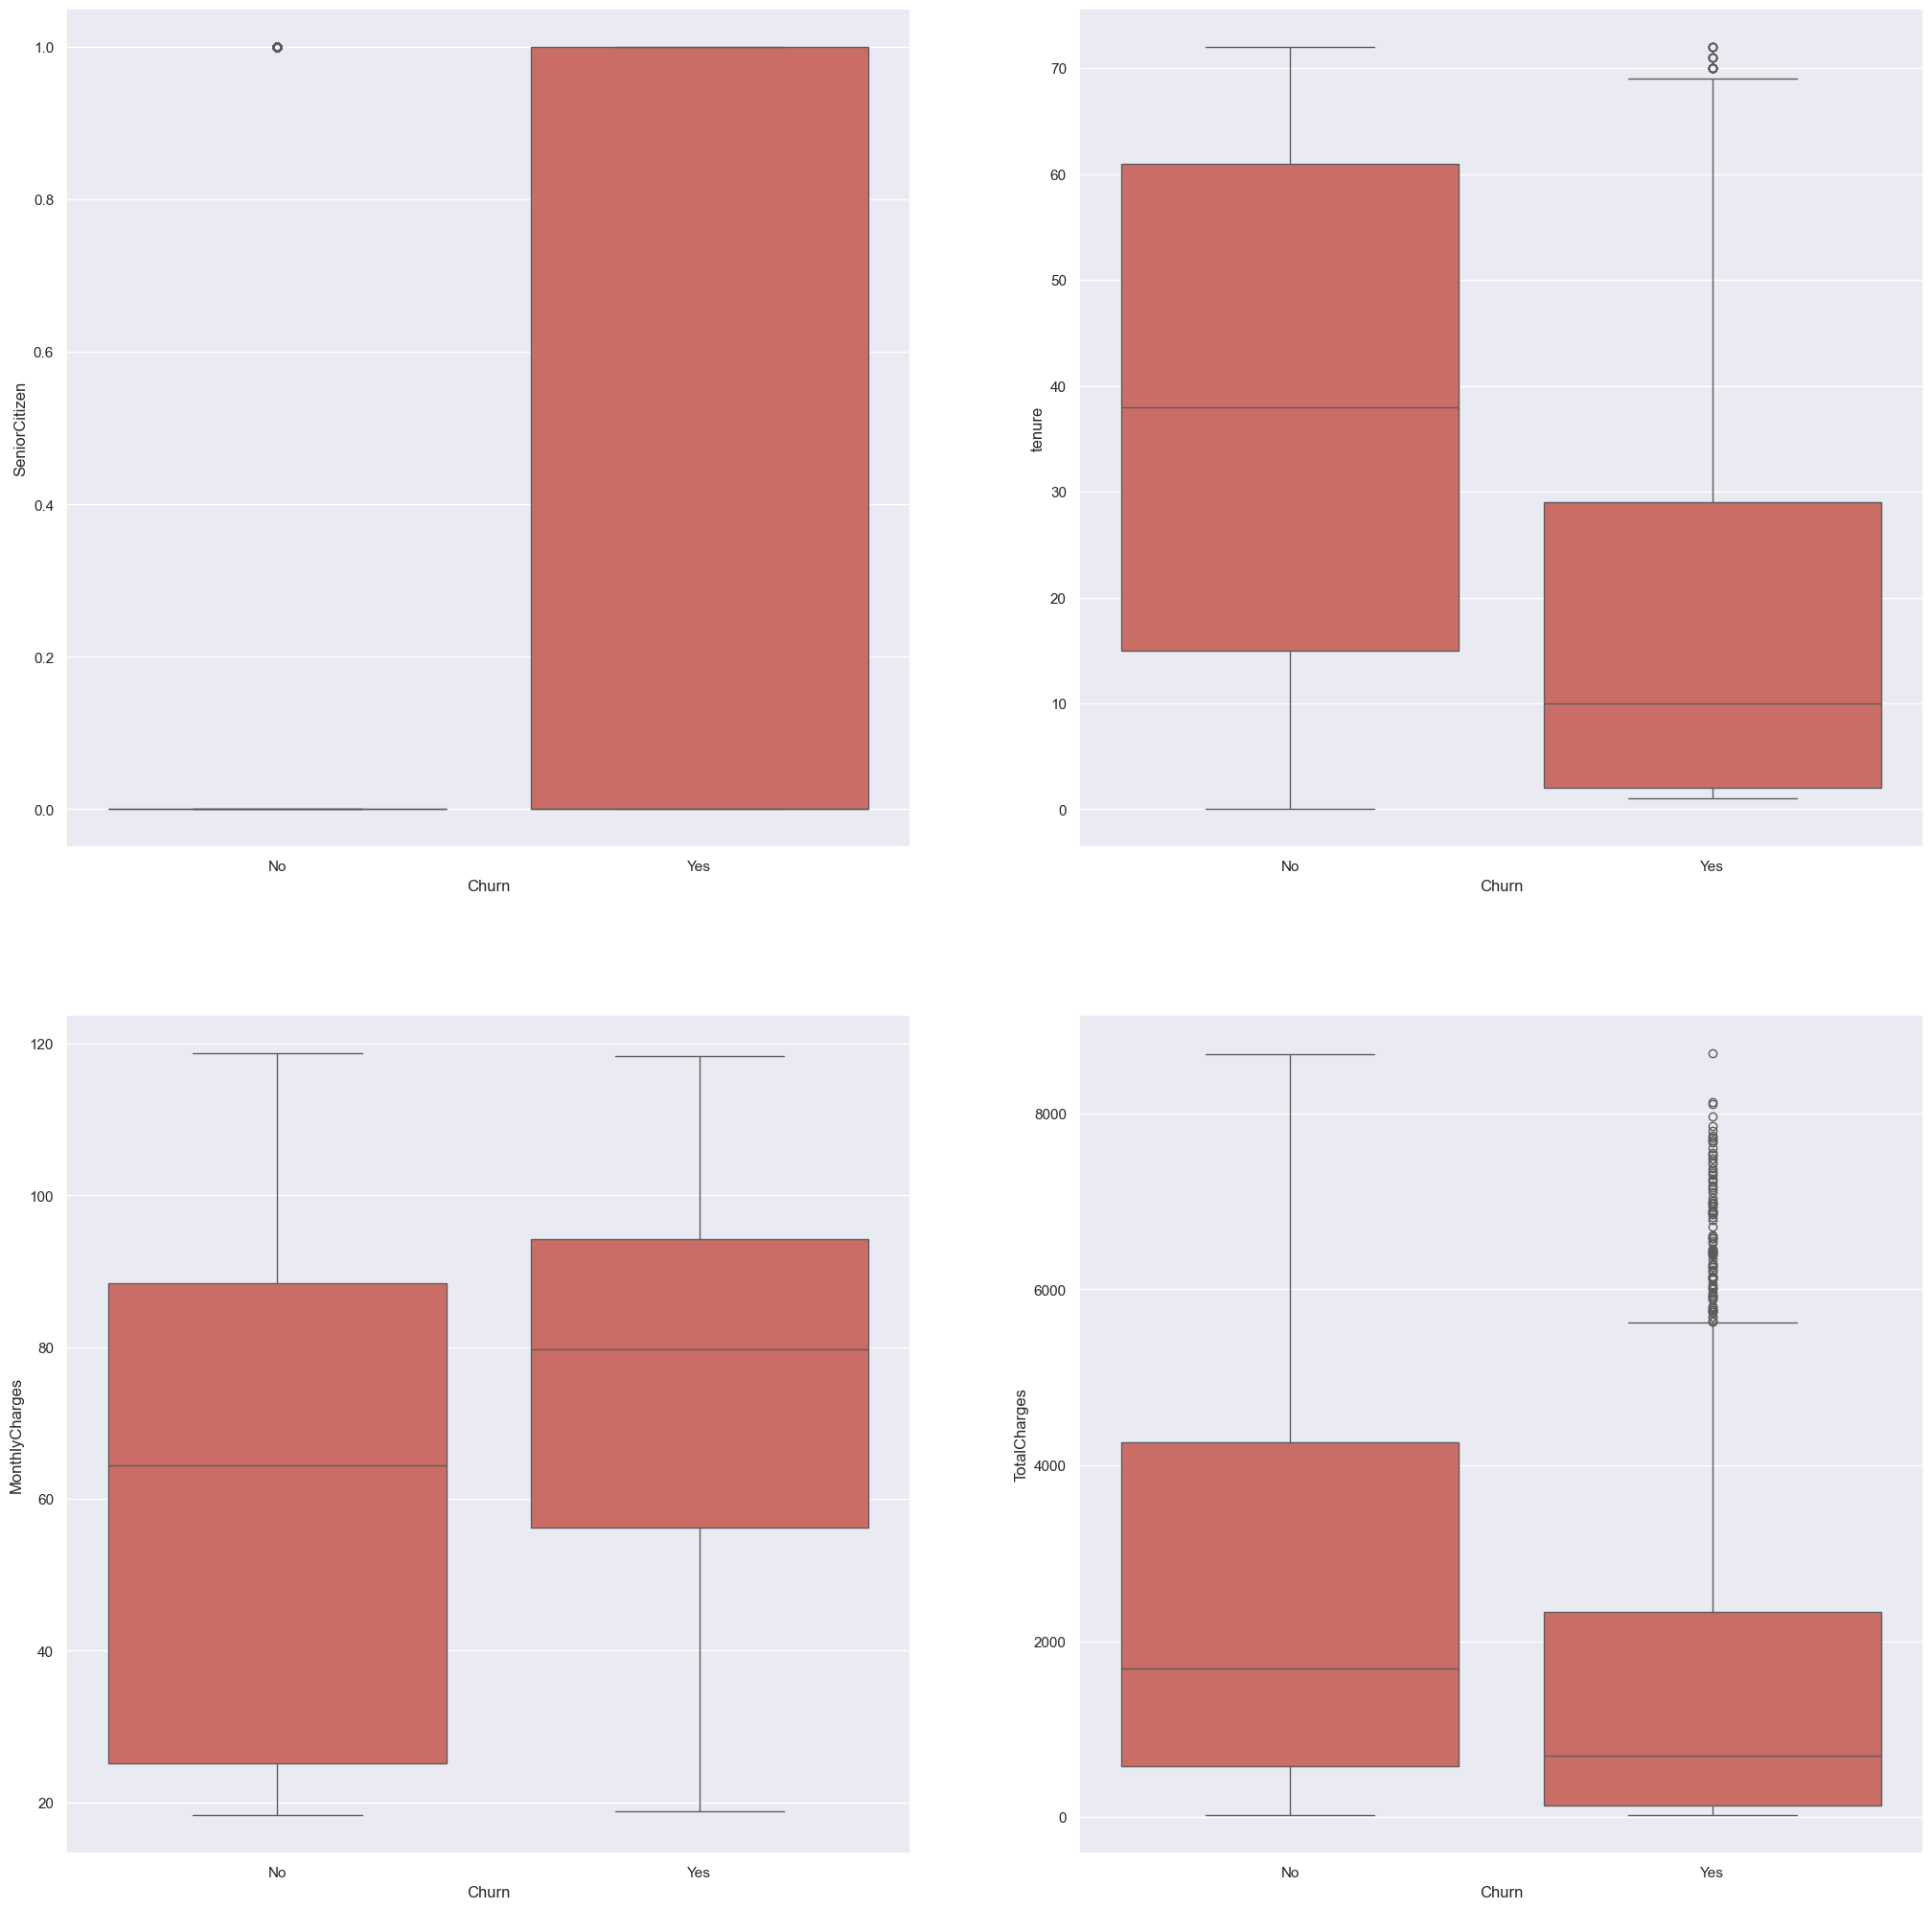

In [59]:
# Plot boxplots of numerical columns. More variation in the boxplot implies higher significance. 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4]

for i in range(len(continuous_features)):
    sns.boxplot(x = 'Churn', y = continuous_features[i], data=df, ax=ax[i])

## 3.0 Create a model

Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

### 3.1 Split the data into training and test sets

In [60]:
train_data, test_data = train_test_split(df_data_1, test_size=0.2, random_state=24)

print("Number of records for training:", len(train_data))
print("Number of records for evaluation:", len(test_data))

Number of records for training: 5634
Number of records for evaluation: 1409


### 3.3 Use StringIndexer to encode a string column of labels to a column of label indices

We are using the Pipeline package to build the development steps as pipeline. 
We are using StringIndexer to handle categorical / string features from the dataset. StringIndexer encodes a string column of labels to a column of label indices

We then use VectorAssembler to asemble these features into a vector. Pipelines API requires that input variables are passed in  a vector

In [61]:
from sklearn.preprocessing import LabelEncoder

cols_to_encode = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                  'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                  'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                  'PaperlessBilling', 'PaymentMethod']

label_encoders = {}

for col in cols_to_encode:
    le = LabelEncoder()
    df_data_1[col] = le.fit_transform(df_data_1[col])
    label_encoders[col] = le


In [62]:
from sklearn.preprocessing import LabelEncoder

# Encode the target column 'Churn'
label_encoder = LabelEncoder()
df_data_1['label'] = label_encoder.fit_transform(df_data_1['Churn'])

# Store the mapping to convert predictions back to original labels
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

### 3.5 Create a pipeline, and fit a model using RandomForestClassifier 
Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Define column types
categorical_cols = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
                    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
                    "PaperlessBilling", "PaymentMethod"]

numeric_cols = ["SeniorCitizen", "TotalCharges", "MonthlyCharges"]

# Preprocessing for numeric features: scaling
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Preprocessing for categorical features: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Full pipeline: preprocessing + classifier
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])


In [64]:
model_pipeline.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [35]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
print("areaUnderROC = %g" % area_under_curve)

NameError: name 'model' is not defined

## 4.0 Save the model and test data

Now the model can be saved for future deployment. The model will be saved using the Watson Machine Learning client, to a deployment space.

**<font color='red'><< UPDATE THE VARIABLE 'MODEL_NAME' TO A UNIQUE NAME>></font>**

**<font color='red'><< UPDATE THE VARIABLE 'DEPLOYMENT_SPACE_NAME' TO THE NAME OF THE DEPLOYMENT SPACE CREATED PREVIOUSLY>></font>**

In [ ]:

MODEL_NAME = "INSERT-YOUR-MODEL-NAME-HERE"
DEPLOYMENT_SPACE_NAME = 'INSERT-YOUR-DEPLOYMENT-SPACE-NAME-HERE'


### 4.1 Save the model to ICP4D local Watson Machine Learning

<font color='red'>Replace the `username` and `password` values of `*****` with your Cloud Pak for Data `username` and `password`. The value for `url` should match the `url` for your Cloud Pak for Data cluster.</font>

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_credentials = {
                   "url": "******",
                   "username": "*****",
                   "password" : "*****",
                   "instance_id": "wml_local",
                   "version" : "2.5.0"
                  }

client = WatsonMachineLearningAPIClient(wml_credentials)

In [ ]:
client.spaces.list()

### Use the desired space as the `default_space`

The deployment space ID will be looked up based on the name specified above. If you do not receive a space GUID as an output to the next cell, do not proceed until you have created a deployment space.

In [ ]:
# Be sure to update the name of the space with the one you want to use.
client.spaces.list()
all_spaces = client.spaces.get_details()['resources']
space_id = None
for space in all_spaces:
    if space['entity']['name'] == DEPLOYMENT_SPACE_NAME:
        space_id = space["metadata"]["guid"]
        print("\nDeployment Space GUID: ", space_id)

if space_id is None:
    print("WARNING: Your space does not exist. Create a deployment space before proceeding to the next cell.")
    #space_id = client.spaces.store(meta_props={client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["guid"]

**<font color='red'><< REPLACE space_id BELOW with the id for your space. For e.g.<br/>client.set.default_space("6b39c537-f707-4078-9dc7-ce70b70ab22f") >></font>**

In [ ]:
# Now set the default space to the GUID for your deployment space. If this is successful, you will see a 'SUCCESS' message.
client.set.default_space(space_id)

#### Save the Model

In [ ]:
# Store our model
model_props = {client.repository.ModelMetaNames.NAME: MODEL_NAME,
               client.repository.ModelMetaNames.RUNTIME_UID : "spark-mllib_2.3",
               client.repository.ModelMetaNames.TYPE : "mllib_2.3"}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train_data)

print(json.dumps(published_model, indent=3))

In [ ]:
# Use this cell to do any cleanup of previously created models and deployments
client.repository.list_models()
client.deployments.list()

# client.repository.delete('GUID of stored model')
# client.deployments.delete('GUID of deployed model')


## 5.0 Save Test Data

We will save the test data we used to evaluate the model to our project.

In [ ]:
write_score_CSV=test_data.toPandas().drop(['Churn'], axis=1)
write_score_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLBatchScore.csv', sep=',', index=False)
#project.save_data('TelcoCustomerSparkMLBatchScore.csv', write_score_CSV.to_csv())

write_eval_CSV=test_data.toPandas()
write_eval_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLEval.csv', sep=',', index=False)
#project.save_data('TelcoCustomerSparkMLEval.csv', write_eval_CSV.to_csv())

## Congratulations, you have created a model based on customer churn data, and deployed it to Watson Machine Learning!